<a href="https://colab.research.google.com/github/amandatz/computational-linear-algebra/blob/main/Atividade6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 6

Amanda Topanotti Zanette (22100776)

**Importações e funções auxiliares**

In [1]:
using LinearAlgebra, SparseArrays, Plots


Esse trecho de código é usado apenas para garantir a repetibilidade dos números aleatórios gerados.

In [2]:
using Random
Random.seed!(123)

TaskLocalRNG()

### Questão 1

In [3]:
function gauss_seidel(A, b, x0; tol=1e-8, max_iter=1000)
  n = length(b)
  x = copy(x0)

  residuals = Float64[]
  residual = norm(A * x - b)
  push!(residuals, residual)

  for iter in 1:max_iter
    x_old = copy(x)

    for i in 1:n
      sum_upd = dot(A[i, 1:i-1], x[1:i-1])
      sum_n_upd = dot(A[i, i+1:n], x_old[i+1:n])

      x[i] = (b[i] - sum_upd - sum_n_upd) / A[i, i]
    end

    residual = norm(A * x - b)
    push!(residuals, residual)

    if residual < tol
      return x, residuals, iter
    end
  end

  return x, residuals, max_iter
end

gauss_seidel (generic function with 1 method)

In [4]:
function gradiente_conjugado(A, b, x0; tol=1e-8, max_iter=1000)
  x = copy(x0)
  r = b - A * x
  p = copy(r)
  rsold = dot(r, r)
  residuals = [sqrt(rsold)]

  for iter in 1:max_iter
    Ap = A * p
    alpha = rsold / dot(p, Ap)

    x .+= alpha .* p
    r .-= alpha .* Ap

    rsnew = dot(r, r)
    push!(residuals, sqrt(rsnew))

    if sqrt(rsnew) < tol
      return x, residuals, iter
    end

    beta = rsnew / rsold
    p .= r .+ beta .* p
    rsold = rsnew
  end

  return x, residuals, max_iter
end

gradiente_conjugado (generic function with 1 method)

### Questão 2

In [5]:
function matriz_bloco_tridiagonal(m, n)
    T = spdiagm(-1 => fill(-1.0, n-1),
                 0 => fill(4.0, n),
                 1 => fill(-1.0, n-1))

    A = blockdiag([T for _ in 1:m]...)

    I_bloco = spdiagm(0 => fill(-1.0, n))
    for k in 1:m-1
        rows = (k-1)*n+1:k*n
        cols = k*n+1:(k+1)*n
        A[rows, cols] = I_bloco
        A[cols, rows] = I_bloco
    end
    return A
end

matriz_bloco_tridiagonal (generic function with 1 method)

In [6]:
function testar_sistemas(m, n)
    println("\n========================================")
    println("Resolvendo para m = $m, n = $n")
    println("Tamanho da matriz: $(m*n)×$(m*n)")
    println("========================================")

    @time begin
      A = matriz_bloco_tridiagonal(m, n)
      e = ones(m*n)
      b = A*e
      x0 = zeros(m*n)

      println("\n ===== Gradiente Conjugado =====")
      x_gc, res_gc, iter_gc = gradiente_conjugado(A, b, x0)

      println("\n Solução encontrada (x):")
      println(x_gc)
      println("\nNúmero de iterações: ", iter_gc)
      println("Resíduo final:       ", res_gc)

      println("\n ===== Gauss-Seidel =====")
      x_gs, res_gs, iter_gs = gauss_seidel(A, b, x0)

      println("\n Solução encontrada (x):")
      println(x_gs)
      println("\nNúmero de iterações: ", iter_gs)
      println("Resíduo final:       ", res_gs)

      # Plotagem
      p = plot(title="Comparação para n=$n (Tamanho $(m*n)×$(m*n))",
               xlabel="Iterações", ylabel="‖r‖₂ (log)",
               yscale=:log10, legend=:topright)

      plot!(p, res_gc, label="Grad. Conjugado ($iter_gc iter)", lw=2)
      plot!(p, res_gs, label="Gauss-Seidel ($iter_gs iter)", lw=2)

      display(p)
  end
end

testar_sistemas (generic function with 1 method)

Os resultados a seguir demonstram que, para $n=10,100,1000$, o método do Gradiente Conjugado é mais eficaz que o de Gauss-Seidel.


Resolvendo para m = 10, n = 10
Tamanho da matriz: 100×100

 ===== Gradiente Conjugado =====

 Solução encontrada (x):
[1.0000000000000002, 1.0, 0.9999999999999999, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0, 0.9999999999999997, 1.0, 1.0, 1.0, 0.9999999999999999, 0.9999999999999999, 1.0, 0.9999999999999998, 0.9999999999999998, 1.0, 1.0000000000000002, 0.9999999999999999, 1.0, 0.9999999999999997, 0.9999999999999999, 1.0000000000000002, 0.9999999999999998, 0.9999999999999999, 1.0, 0.9999999999999998, 0.9999999999999997, 0.9999999999999999, 0.9999999999999997, 0.9999999999999998, 1.0, 0.9999999999999998, 0.9999999999999998, 0.9999999999999997, 0.9999999999999997, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 1.0, 1.0000000000000002, 0.9999999999999998, 0.9999999999999999, 0.9999999999999997, 0.9999999999999996, 0.9999999999999996, 0.9999999999999994, 1.0, 0.9999999999999998, 1.0, 1.0, 0.9999999999999996, 0.9999999999999999, 0.9999999999999997, 0.9999999999999996, 0.999

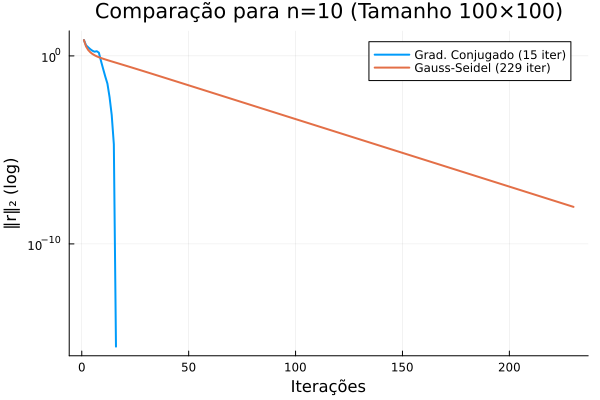

  3.200297 seconds (1.59 M allocations: 129.804 MiB, 9.15% gc time, 92.54% compilation time: 5% of which was recompilation)


In [7]:
A1 = testar_sistemas(10, 10)


Resolvendo para m = 10, n = 100
Tamanho da matriz: 1000×1000

 ===== Gradiente Conjugado =====

 Solução encontrada (x):
[0.999999999972955, 0.9999999999761676, 0.999999999977693, 0.9999999999853785, 1.0000000000206684, 1.0000000000357732, 1.0000000000250955, 0.9999999999848735, 0.9999999999685315, 0.9999999999501661, 0.9999999999644447, 0.999999999953305, 0.9999999999688293, 0.9999999999487911, 0.9999999999648188, 0.9999999998631418, 0.9999999998475101, 0.9999999998003233, 0.999999999912728, 0.9999999999048218, 1.0000000000217746, 1.0000000000394587, 1.0000000001018718, 1.0000000001487386, 1.000000000196141, 1.0000000002526366, 1.0000000001860396, 1.0000000002065788, 1.000000000057967, 1.0000000000004323, 0.9999999999132128, 0.9999999998758765, 0.9999999999253024, 0.9999999999279853, 0.9999999999626263, 0.9999999999870501, 1.0000000000775342, 1.0000000000570344, 1.0000000000636686, 1.000000000076264, 1.0000000000042928, 1.000000000139364, 1.0000000000682934, 0.9999999997673191, 0.999

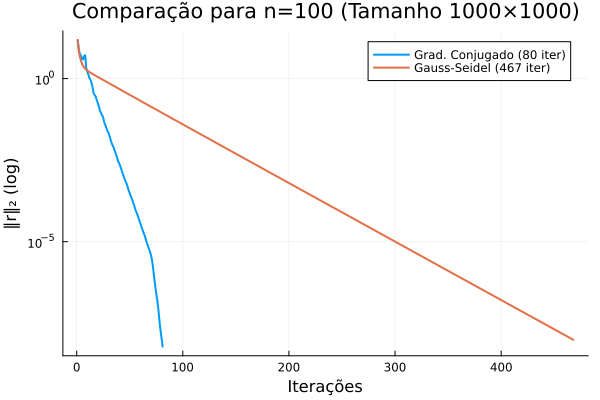

  4.369390 seconds (4.76 M allocations: 3.868 GiB, 9.67% gc time)


In [8]:
A2 = testar_sistemas(10, 100)


Resolvendo para m = 10, n = 1000
Tamanho da matriz: 10000×10000

 ===== Gradiente Conjugado =====

 Solução encontrada (x):
[0.999999999982251, 1.0000000000154754, 1.0000000000231832, 1.0000000000231897, 1.0000000000025908, 0.9999999999930855, 0.9999999999985559, 1.000000000019207, 1.000000000039737, 1.0000000000665548, 1.0000000000939728, 1.0000000000942904, 1.0000000000588554, 1.0000000000589746, 1.0000000001040876, 1.000000000107645, 1.0000000001649898, 1.0000000001156657, 1.0000000001212546, 1.000000000042308, 1.0000000000116935, 0.9999999999540834, 0.9999999999254541, 0.9999999998541688, 0.9999999998216023, 0.9999999998410015, 0.9999999998356158, 0.9999999998798709, 0.9999999998765118, 0.999999999995309, 1.0000000000154607, 1.0000000001304956, 1.0000000001800722, 1.0000000001213825, 1.000000000170889, 1.0000000000149611, 0.9999999999300333, 0.9999999999552884, 0.9999999999469991, 0.9999999999793306, 0.9999999999911592, 0.9999999999469894, 0.9999999999394145, 1.0000000000034668, 0

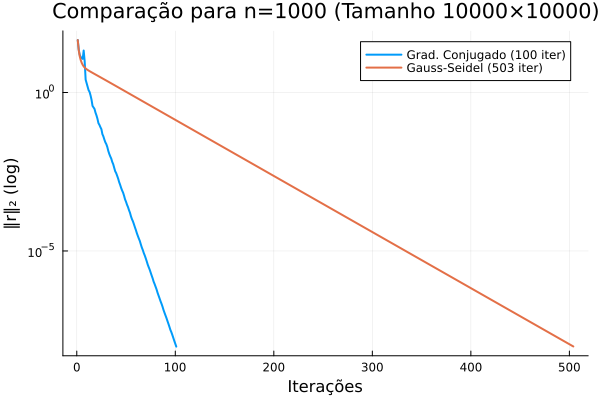

306.166144 seconds (58.93 M allocations: 378.437 GiB, 2.70% gc time)


In [9]:
A3 = testar_sistemas(10, 1000)

### Questão 3

Sabemos que na decomposição $A=QDQ^T$, em que $Q$ é ortogonal e $D$ é diagonal, as matrizes $A$ e $D$ possuem os mesmos autovalores. A partir disso, estaremos gerando a matriz A.

In [10]:
function matriz_simetrica(autovalores)
    N = length(autovalores)

    D = diagm(autovalores)

    Q, _ = qr(randn(N, N))

    A = Q * D * Q'

    # Garante que a matriz seja simétrica
    return (A + A') / 2
end


matriz_simetrica (generic function with 1 method)

In [11]:
n=1000
e = ones(Float64, n)
x0 = zeros(Float64, n);

**a) Valores uniformemente distribuídos no intervalo $[1, 1000]$.**

In [12]:
autovalores_a = collect(range(1.0, stop=1000.0, length=n))
A_a = matriz_simetrica(autovalores_a)
b_a = A_a * e

x_a, res_a, iter_a = gradiente_conjugado(A_a, b_a, x0)

iter_a


208

**b) $\sigma(A) = \{100, 200, 300, \dots, 1000\}$ de mesma multiplicidade.**

In [13]:
autovalores_b = repeat(100:100:1000, inner=100)
A_b = matriz_simetrica(autovalores_b)
b_b = A_b * e

x_b, res_b, iter_b = gradiente_conjugado(A_b, b_b, x0)

iter_b


10

**c) $\sigma(A) = \{1, 100000\}$ com mesma multiplicidade.**

In [14]:
autovalores_c = repeat([1,100000],inner = 500)
A_c = matriz_simetrica(autovalores_c)
b_c = A_c * e

x_c, res_c, iter_c = gradiente_conjugado(A_c, b_c, x0)

iter_c


3

Os resultados confirmam a propriedade teórica de que o método do Gradiente Conjugado converge em no máximo $r$ iterações, em que $r=∣\sigma(A)∣$ é o número de autovalores distintos da matriz.

**a)** Possui 1000 autovalores distintos e convergiu em 208 iterações;

**b)** Possui 10 autovalores distintos e convergiu em 10 iterações;

**c)** Possui 2 autovalores distintos e convergiu em 3 iterações. Nesse caso, é esperado devido a erros de ponto flutuante.
